# EEG Signal Processing: Isolating the P300 Event-Related Potential
---
Pipeline: Raw Data → Filtering → Epoching → Artifact Rejection → Baseline Correction → Averaging → Statistical Analysis → Topomap


## Raw Data

In [6]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.8 MB/s eta 0:00:00


In [7]:
# EEG P300 Analysis - Project Setup
import mne
import numpy as np
import matplotlib.pyplot as plt
mne.__version__

'1.10.2'

In [8]:
from mne.datasets import sample
data_path = sample.data_path() # Get the path
raw = mne.io.read_raw_fif(data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif') # Load the raw EEG data file
raw.load_data()
raw

Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 366GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 02m00s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MiB, data loaded>

EEG signals are very small (typically 10-100 μV)

Without scaling, the plot would be too squished to see anything

eeg=100e-6: Sets the display scale to 100 μV (microvolts)

100e-6 = 0.0001 volts = 100 microvolts

Using matplotlib as 2D backend.


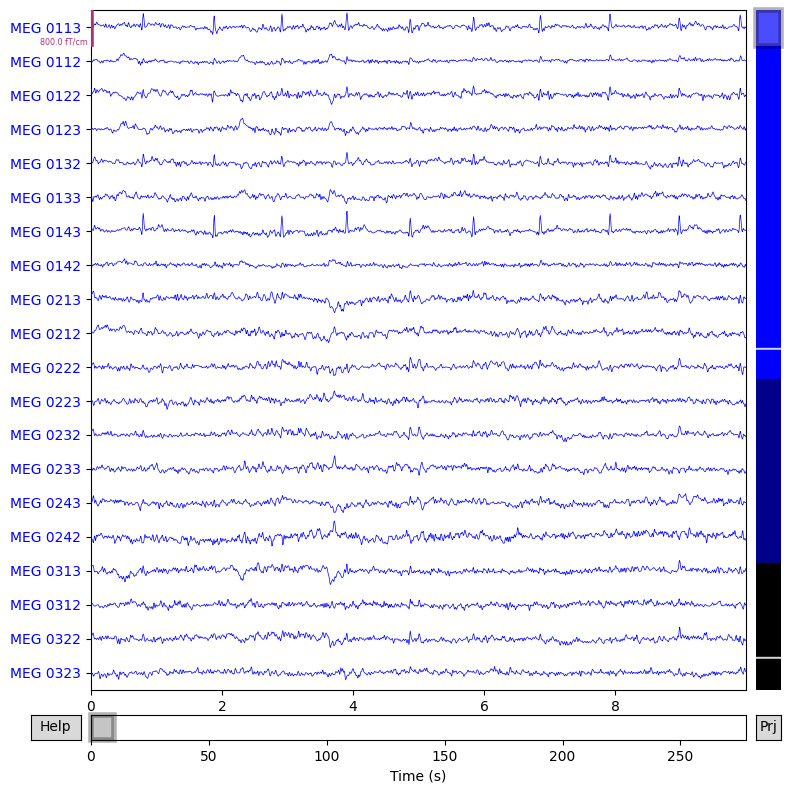

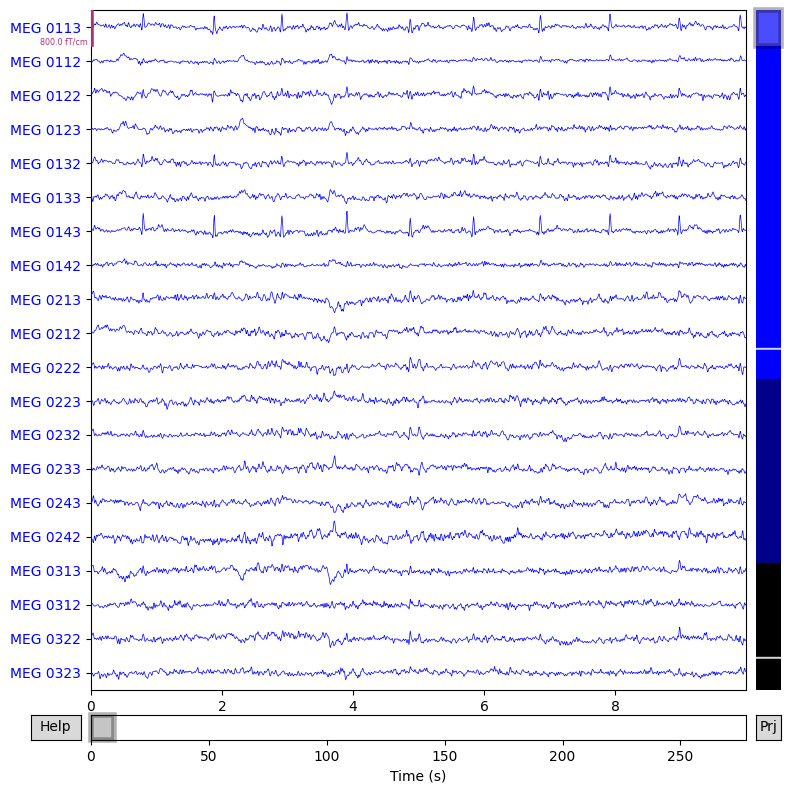

In [9]:
# Plot the first 10 seconds of raw (unfiltered) EEG data
raw.plot(duration=10, scalings=dict(eeg=100e-6))

## Filtering

Below 1 Hz: Slow drifts from sweat, skin potentials, movement artifacts

Above 30 Hz: Muscle noise (EMG), high-frequency interference

---

Brain waves of interest:

Delta (1-4 Hz): Deep sleep

Theta (4-8 Hz): Drowsiness, meditation

Alpha (8-13 Hz): Relaxed, eyes closed

Beta (13-30 Hz): Active thinking, focus

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 497 samples (3.310 s)



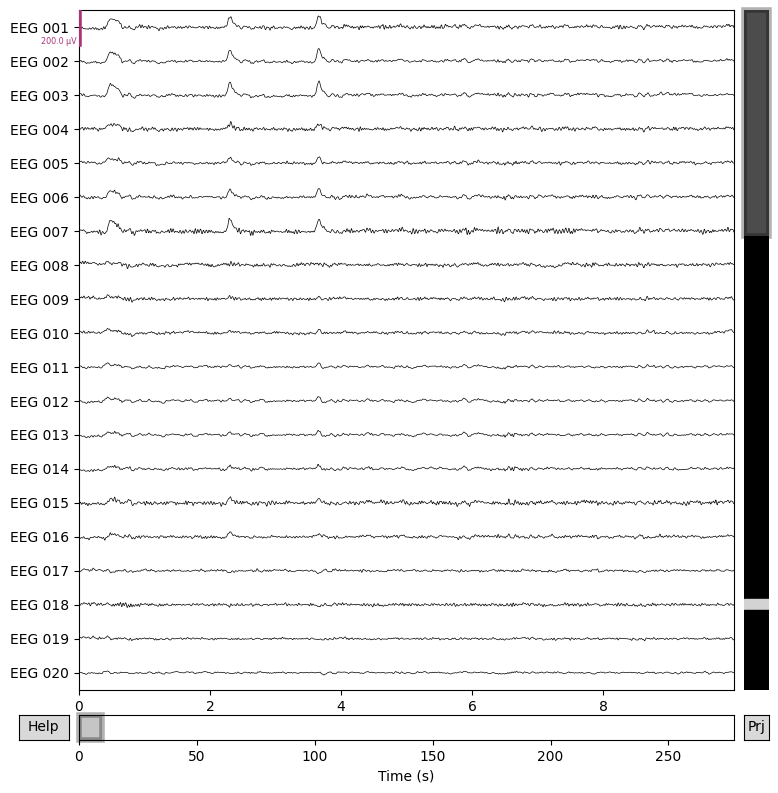

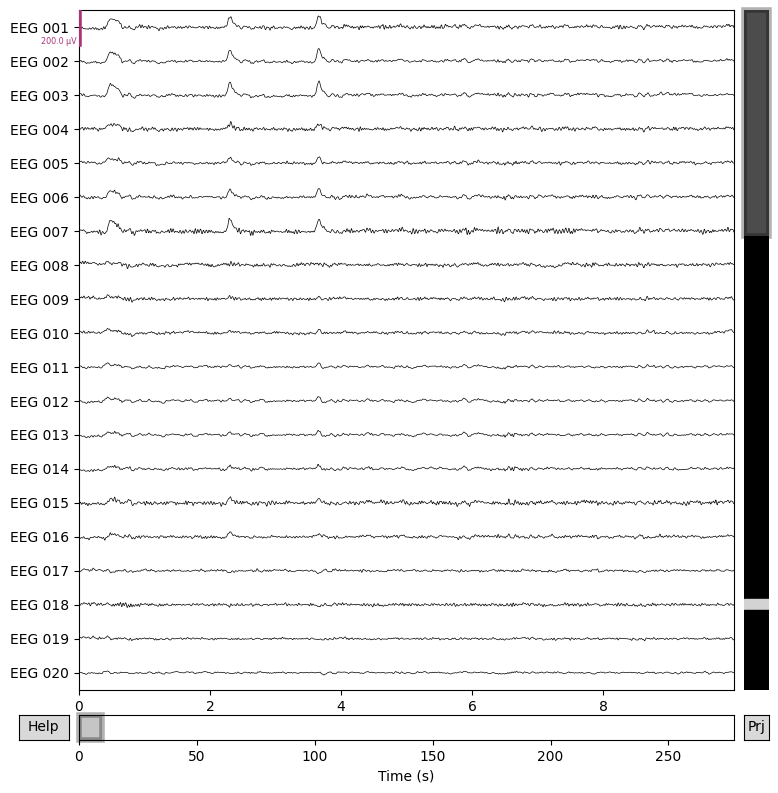

In [10]:
# Pick only EEG channels (exclude MEG(Magnetoencephalography) and EOG(Electrooculography))
raw.pick(['eeg']) # or use legacy function - raw.pick_types(eeg=True, meg=False, eog=False)

raw.filter(1, 30) # 1-30 Hz

raw.plot(duration=10, scalings=dict(eeg=100e-6)) # Filtered version

## Epoching, Artifact Rejection & Baseline Correction

In [11]:
raw.ch_names # channel names

['EEG 001',
 'EEG 002',
 'EEG 003',
 'EEG 004',
 'EEG 005',
 'EEG 006',
 'EEG 007',
 'EEG 008',
 'EEG 009',
 'EEG 010',
 'EEG 011',
 'EEG 012',
 'EEG 013',
 'EEG 014',
 'EEG 015',
 'EEG 016',
 'EEG 017',
 'EEG 018',
 'EEG 019',
 'EEG 020',
 'EEG 021',
 'EEG 022',
 'EEG 023',
 'EEG 024',
 'EEG 025',
 'EEG 026',
 'EEG 027',
 'EEG 028',
 'EEG 029',
 'EEG 030',
 'EEG 031',
 'EEG 032',
 'EEG 033',
 'EEG 034',
 'EEG 035',
 'EEG 036',
 'EEG 037',
 'EEG 038',
 'EEG 039',
 'EEG 040',
 'EEG 041',
 'EEG 042',
 'EEG 043',
 'EEG 044',
 'EEG 045',
 'EEG 046',
 'EEG 047',
 'EEG 048',
 'EEG 049',
 'EEG 050',
 'EEG 051',
 'EEG 052',
 'EEG 053',
 'EEG 054',
 'EEG 055',
 'EEG 056',
 'EEG 057',
 'EEG 058',
 'EEG 059',
 'EEG 060']

Event markers are timestamps in the EEG recording that mark when something happened in the experiment.

Sample Number : Duration (usually 0) : Event ID (type)

    [15000, 0, 1],  # Standard tone
    [16200, 0, 5],  # TARGET tone (rare!)
    [16700, 0, 1],  # Standard tone

In our experiment,

Event ID 1, 2, 3, 4 = Frequent standard sounds/visuals (80% of trials)

Event ID 5, 6 = Rare target sounds/visuals (20% of trials) ← These should show P300

P300 = A brain signal peaking ~300ms after noticing something rare and important



In [12]:
# Load the event markers from the separate events file
events_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw-eve.fif'
events = mne.read_events(events_fname)

events[:20] # Display the first 20 events

array([[6994,    0,    2],
       [7086,    0,    3],
       [7192,    0,    1],
       [7304,    0,    4],
       [7413,    0,    2],
       [7506,    0,    3],
       [7612,    0,    1],
       [7709,    0,    4],
       [7810,    0,    2],
       [7916,    0,    3],
       [8025,    0,    1],
       [8129,    0,    4],
       [8233,    0,    2],
       [8331,    0,    3],
       [8428,    0,    1],
       [8522,    0,    5],
       [8633,    0,    2],
       [8662,    0,   32],
       [8739,    0,    3],
       [8857,    0,    1]])

In [13]:
len(events) # Total events

319

**Map event numbers to meaningful names for analysis**

**Cut the continuous data into segments around each stimulus**

tmin=-0.2: Start 200ms BEFORE stimulus

tmax=0.8: End 800ms AFTER stimulus

Baseline Correction = Removes DC offset and slow drifts | Makes all trials start from the same "zero point"

reject_threshold = 100e-6 | 100 microvolts | Artifact Rejection

Clean, comparable trials ready for averaging to find the P300


In [29]:
event_id = {
    'target': 5,
    'standard': 1
}

# AUTO-REJECT trials with voltages > 100µV (eyeblinks, etc.)
reject_threshold = 100e-6

epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.8, baseline=(-0.2, 0), reject=dict(eeg=reject_threshold),preload=True)
epochs

Not setting metadata
87 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 87 events and 151 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG :

<Epochs | 71 events (all good), -0.2 – 0.799 s (baseline -0.2 – 0 s), ~7.8 MiB, data loaded,
 'target': 13
 'standard': 58>

In [30]:
print(f"Original events: {len(events)}")
print(f"Epochs after artifact rejection: {len(epochs)}")
print(f"Trials removed: {len(events) - len(epochs)}")

Original events: 319
Epochs after artifact rejection: 71
Trials removed: 248


## Averaging

Average all trials to reveal the Event-Related Potentials

We have 15 target trials (rare sounds) | Each trial has random brain noise + the actual P300 response

Averaging cancels out the random noise | What remains is the clean P300 signal

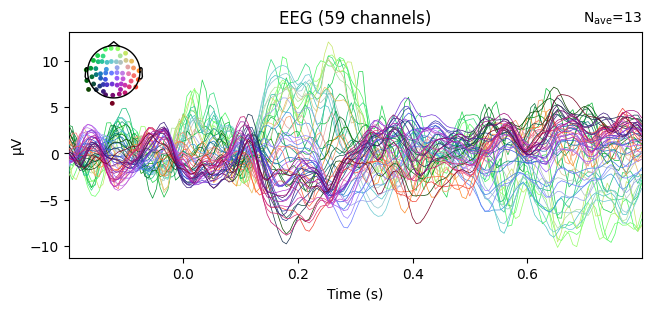

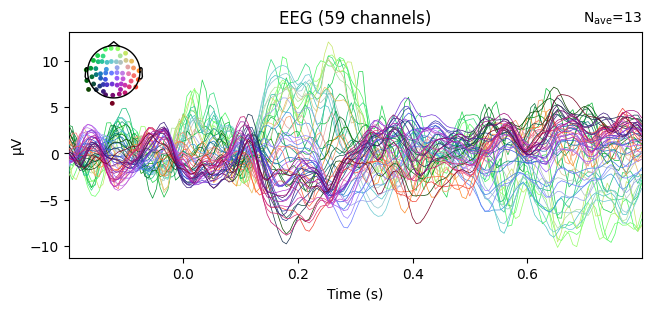

In [31]:
target_erp = epochs['target'].average()
target_erp.plot()

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


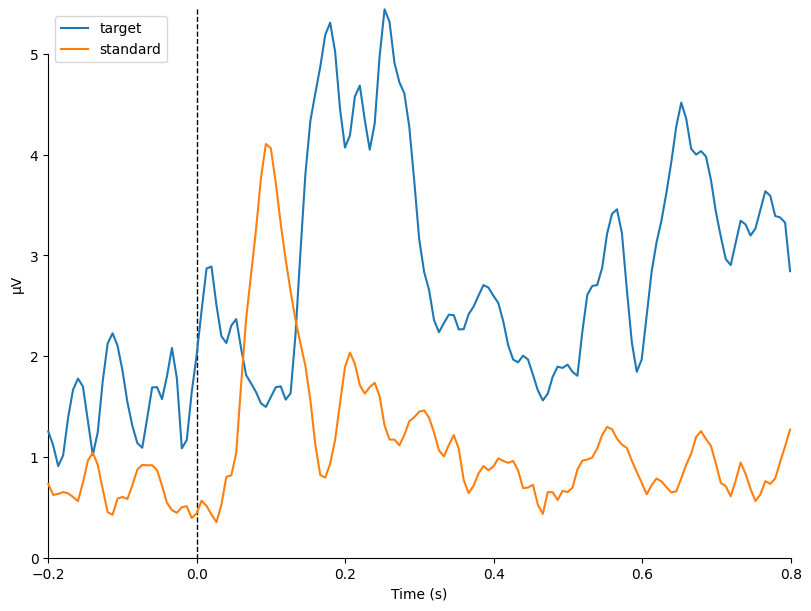

[<Figure size 800x600 with 1 Axes>]

In [32]:
# Plot both conditions together to check validity
standard_erp = epochs['standard'].average()
mne.viz.plot_compare_evokeds({'target': target_erp, 'standard': standard_erp})

## Statistical Analysis

t-test: Compares two groups to see if they're truly different

Large positive t (4.2) = Big difference

Near zero t (0.3) = No real difference


---


p-value: Probability the difference is due to luck

p < 0.05 = There's less than 5% chance this is random → REAL

p > 0.05 = Could be random → fake

---

    Extract voltage data for all trials - 3D Array (trials x channels x time)
    Pick central channel where P300 is strongest
    Find position of EEG 052
    Find exact time of P300 peak
    Compare target vs standard voltages
    Perform t-test and calculate p-value to check if difference is real


In [49]:
target_data = epochs['target'].get_data()
standard_data = epochs['standard'].get_data()

p300_channel = 'EEG 052'
ch_idx = epochs.ch_names.index(p300_channel)
time_idx = np.argmax(target_erp.data[ch_idx, :]) # np.argmax finds the idx of the maximum / peak P300 amplitude
# target_erp.data[ch_idx, :] = all voltages at 'EEG 052' channel

from scipy import stats
t_stat, p_value = stats.ttest_ind(target_data[:, ch_idx, time_idx], standard_data[:, ch_idx, time_idx])
# : = takes all trial, ch_idx = use central channel (EEG 052), time_idx = use peak time

In [50]:
print(f"P300 Statistical Test:")
print(f"Channel: {p300_channel}, Time: {target_erp.times[time_idx]:.3f}s")
print(f"t({len(target_data)+len(standard_data)-2}) = {t_stat:.3f}, p = {p_value:.4f}")

# t(69) = "t-test with 69 degrees of freedom"

P300 Statistical Test:
Channel: EEG 052, Time: 0.766s
t(69) = 3.489, p = 0.0008


## Topomap

A scalp map that shows where brain activity is strongest using colors.

Red/Orange = Strong (+)ve activity (P300)

Blue = (-)ve activity

Green/Yellow = Weak activity

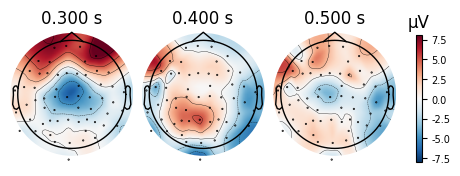

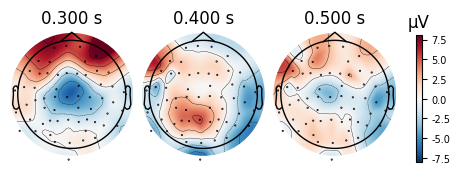

In [51]:
timestamps = [0.3, 0.4, 0.5]  # Look at 300ms, 400ms, and 500ms after stimulus
target_erp.plot_topomap(times=timestamps)

Topography: Centroparietal distribution

**Conclusion: The analysis successfully isolated the P300 ERP (the brain's response to rare, task-relevant stimuli)**

